# Multiparametric MRI - unsupervised (k-means) tissue classification


**HVL-MMIV-DLN-AI-2022**:   `6-sMRI-Kmeans-tissue-classification.ipynb` (_v.2022-05-07 A.L._)<br>

<a href="https://colab.research.google.com/github/MMIV-ML/HVL-MMIV-DLN-AI-2022/blob/main/2-biomedical-imaging/6-sMRI-Kmeans-tissue-classification.ipynb ">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Learning objectives and context

- In this session you will learn to "disect" tissue types in a given multispectral MR image using  machine learning (**unsupervised classification**)


- The unsupervised classification model we wil use is simple **K-means** clustering


- For a more comprehensive introduction to unsupervised classification, see https://github.com/oercompbiomed/Seili-2020/blob/master/machine-learning/02-unsupervised-learning.ipynb

## Unsupervised learning

**Unsupervised** learning is a branch of machine learning that learns from data that has not been labelled, classified, or categorized (as in **supervised** learning). Unsupervised learning identifies commonalities or previously unknown patterns in the data. The goal for unsupervised learning can be to model the underlying structure or distribution in the data in order to learn more about the data.

Using unsupervised learning to discover inherent groupings in the data is often denoted **clustering**, for which [K-means](https://en.wikipedia.org/wiki/K-means_clustering) is a prominent class of algorithms for splitting data into groups according to similarity, employing an iterative refinement technique to attain an optimal solution. This will also result in a partitioning of the data space into [Voronoi cells](https://en.wikipedia.org/wiki/Voronoi_diagram), that can be usede for cluster prediction of new data points.

## What is K-means?

Illustrative example adapted from: http://www.bigendiandata.com/2017-04-18-Jupyter_Customer360/ (Ian Downard)

[K-means clustering](https://en.wikipedia.org/wiki/Cluster_analysis) aims to group a set of **_objects_** with attributes (**_features_**) in such a way that objects in the same group (or cluster) are more **_similar_** to each other with respect to their attribute values than to objects in other groups. It operates on a table where every entry is an attribute value of a given object. <br>K-means only supports numeric attributes (columns). In python such table is often represented as a Pandas dataframe. A dataframe with two columns can easily be visualized as a scatterplot, where the x-axis is the first column (or attribute) and the y-axis is the second column. 

**Multispectral image DATA**

We will be using a four-channel multispectral image (slice 60 from a multispectral 3D recording),  <br>
reported in  Lundervold et al. Volume distribution of cerebrospinal fluid using multispectral MR
imaging. <br> _Medical Image Analysis_ 2000;4:123-136. https://www.ncbi.nlm.nih.gov/pubmed/10972326, [[PDF](https://drive.google.com/file/d/17Ut1ScHU4cX5x_EHwQnNwH_q3Lgcq5WA/view)]<br>
and a manually delineated `brain ROI mask` for spatial restriction of the unsupervised pixel classification

## Setup

In [1]:
# This is a quick check of whether the notebook is currently running 
# on Google Colaboratory
if 'google.colab' in str(get_ipython()):
    print('The notebook is running on Colab. colab=True.')
    colab=True
    !pip install gdown
    !pip install nibabel
    !pip install nilearn
    !pip install scikit-image
    !pip install scikit-learn
    !pip install imageio
    !pip install pydicom
    !wget -O utils.py https://raw.githubusercontent.com/MMIV-ML/HVL-MMIV-DLN-AI-2022/master/2-biomedical_imaging/utils.py
else:
    print('The notebook is not running on Colab. colab=False.')
    colab=False

The notebook is not running on Colab. colab=False.


### Download zipped data from Google Drive using gdown [for running in Colab]

In [2]:
import gdown
import shutil
import os
import sys

**Download assets.zip file if ./assets does not exist (as when running in Colab)**

In [3]:
if os.path.isdir('./assets') == False:
    
    ## Download assets.zip from Google Drive (My Drive -> HVL-MMIV-DLN-AI-2022/)
    # https://drive.google.com/file/d/1xwjHRB2irvNsIizf7CcgxxYfiUq5Xi9f/view?usp=sharing
    
    # https://drive.google.com/file/d/1yH0VwGndgguhul5A8QZKUZvHuNnrOEYf/view?usp=sharing
          
    file_id = '1yH0VwGndgguhul5A8QZKUZvHuNnrOEYf'
    url = f'https://drive.google.com/uc?id={file_id}'
    output = './assets.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets.zip file into `./assets`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `assets.zip` file
    os.remove(output)
else:
    print(f'./assets  exists already and will not be overwritten!')

./assets  exists already and will not be overwritten!


**If `./data` does not extists, download data files (not on GitHub repository) from Google Drive using gdown (https://github.com/wkentaro/gdown)**

In [4]:
if os.path.isdir('./data') == False:
    
    ## Download data.zip from Google Drive  (My Drive -> HVL-MMIV-DLN-AI-2022/)
    # https://drive.google.com/file/d/1yJ7nss4qS40Jc-h-WXhfJOV2LYMdAfEO/view?usp=sharing
    
    file_id = '1yJ7nss4qS40Jc-h-WXhfJOV2LYMdAfEO'
    url = f'https://drive.google.com/uc?id={file_id}'
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the data.zip file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already and will not be overwritten!')

./data  exists already and will not be overwritten!


### Set up libraries and folders

In [5]:
import gdown
import shutil
import sys
import os
from os.path import expanduser, join, basename, split
import glob
import platform
import pathlib
import pandas as pd
import numpy as np
import json
import imageio
import pydicom as dicom
import tifffile as tiff
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import skimage
from skimage import io
import nilearn
from nilearn import datasets, plotting, image
import sklearn
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix 

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [6]:
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)
print('Matplotlib version ' + matplotlib.__version__)
print('Seaborn version ' + sns.__version__)
print('Imageio version ' + imageio.__version__)
print('Scikit-image version ' + skimage.__version__)
print('Tifffile version ' + tiff.__version__)
print('Nibabel version ' + nib.__version__)
print('Nlearn version ' + nilearn.__version__)
print('Pydicom version ' + dicom.__version__)
print('Scikit-learn version ' + sklearn.__version__)

Python version 3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:19) 
[Clang 9.0.0 (tags/RELEASE_900/final)]
Pandas version 1.4.2
Numpy version 1.22.3
Matplotlib version 3.5.1
Seaborn version 0.11.2
Imageio version 2.19.0
Scikit-image version 0.19.2
Tifffile version 2021.11.2
Nibabel version 3.2.2
Nlearn version 0.9.1
Pydicom version 2.3.0
Scikit-learn version 1.0.2


In [7]:
cwd = os.getcwd()
working_dir = join(cwd, 'data')
HOME = os.path.expanduser('~')  # To make path to local home directory

Check your platform when running this notebook

In [8]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 21.4.0: Fri Mar 18 00:45:05 PDT 2022; root:xnu-8020.101.4~15/RELEASE_X86_64)


### An intial K-means example using synthetic data

(modified from the "Python Data Science Handbook" by Jake VanderPlas)

In [9]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# create 50 separable points
X, y = make_blobs(n_samples=100, centers=4,
                  random_state=42, cluster_std=1.5)

# Fit the K Means model
model = KMeans(4, random_state=0)
y = model.fit_predict(X)

In [10]:
centroids = model.cluster_centers_

**Plot the input data (without cluster labels)**

In [11]:
# Make a function for common plot formatting
def format_plot(ax, title):
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xlabel('feature 1', color='black')
    ax.set_ylabel('feature 2', color='black')
    ax.set_title(title, color='black')

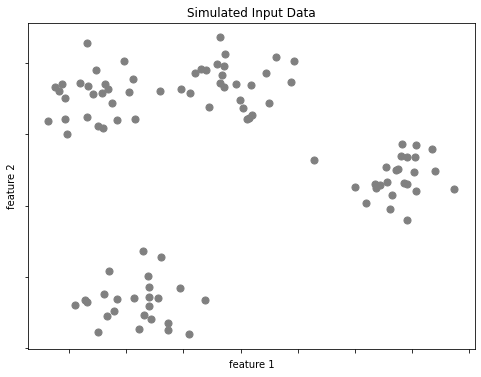

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[:, 0], X[:, 1], s=50, color='gray')

# format the plot
format_plot(ax, 'Simulated Input Data')

plt.show()
# fig.savefig('assets/k-means-clustering-example_1.png')

**Plot the data with color-coded cluster labels and star-shaped cluster centroids**

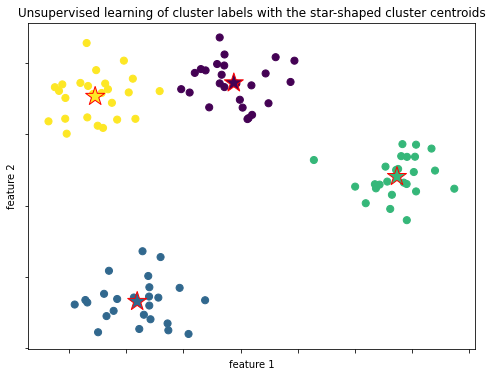

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[:, 0], X[:, 1], s=50, c=y, cmap='viridis')
ax.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=400, c=range(4), cmap='viridis', edgecolors = 'red')

# format the plot
format_plot(ax, 'Unsupervised learning of cluster labels with the star-shaped cluster centroids')

plt.show()
# fig.savefig('assets/k-means-clustering-example-2.png')

### Using clustering for (color) image segmentation

In [14]:
from matplotlib.image import imread
image = imread(os.path.join("./assets","ladybug.png"))
image.shape

(533, 800, 3)

In [15]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [16]:
%%time
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

CPU times: user 5min 8s, sys: 14.1 s, total: 5min 22s
Wall time: 24.7 s


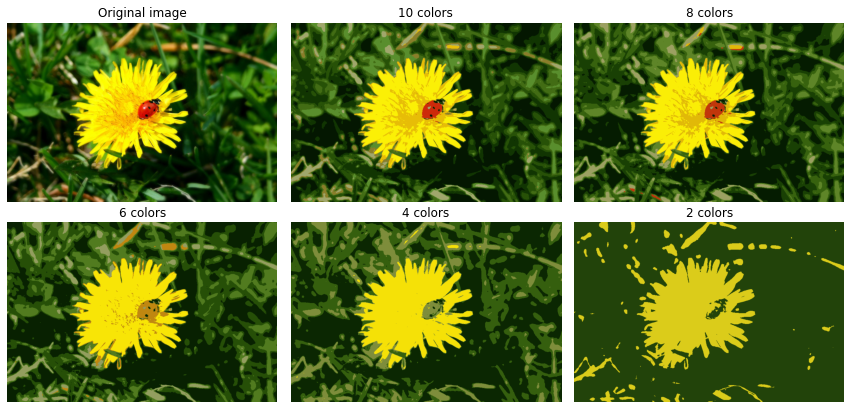

In [17]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

## Then:  our multispectral MRI data

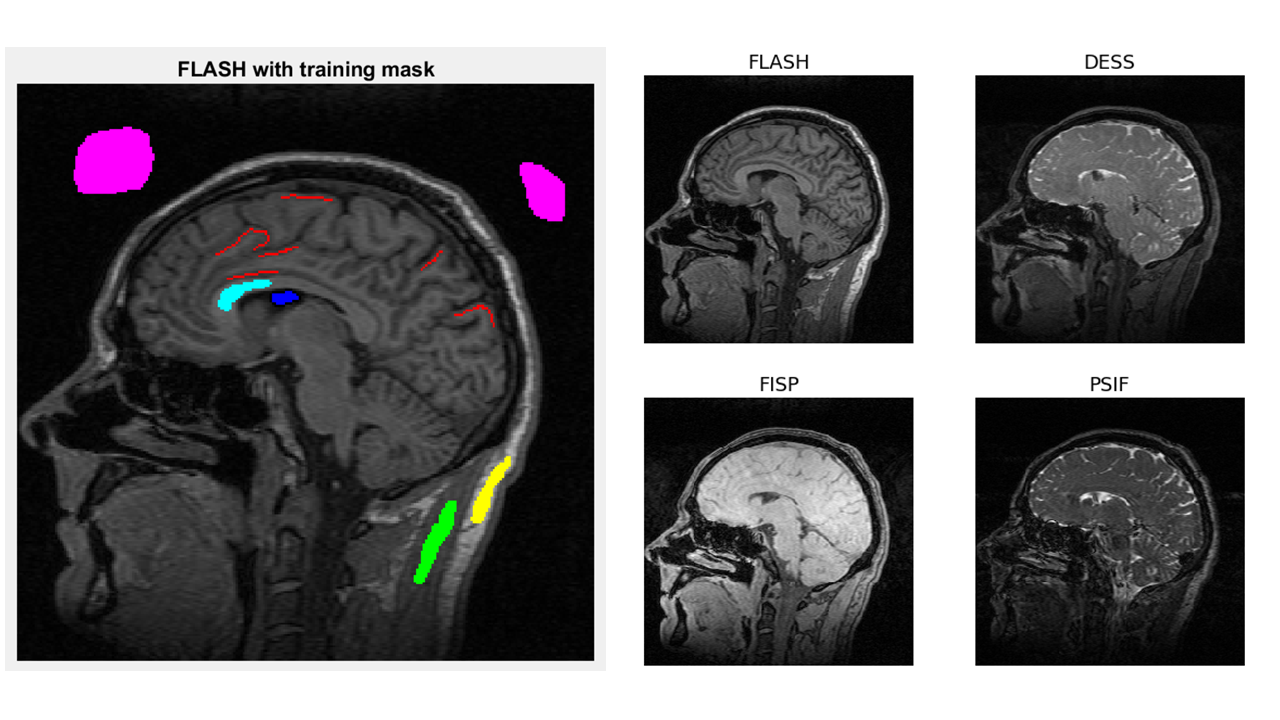

In [18]:
from IPython.display import Image
Image(filename='./assets/multispectral_tissue_classification_pptx.png', width=600)

**Define the channel names (MRI pulse sequence acronyms)**

In [19]:
chn_names = ['FLASH', 'DESS', 'FISP', 'PSIF']

## Read the multispectral MR image and the binary ROI mask

In [20]:
# Using nibabel to read the multispectral image (and the ROI mask)
fn_multispectral = './data/mri/multispectral_mri.nii.gz'
img = nib.load(fn_multispectral)
fn_roimsk = './data/mri/brain_roi_mask.nii.gz'
roimsk = nib.load(fn_roimsk)

**Print properties of the multispectral NIFTI image**

In [21]:
print('**Multispectral image info:**')
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
dat = img.get_fdata()
print('min = %.1f' % dat.min())
print('max = %.1f' % dat.max())
print('number of channels =', img.shape[-1])
# Collaps the singular (z-)dimension
data = np.uint16(dat.squeeze())
print('shape of 2D+spectral data = ',data.shape)
print('dtype of 2D+spectral data = ',data.dtype)
print('img affine:', img.affine)

**Multispectral image info:**
shape of image =  (256, 256, 1, 4)
units =  ('unknown', 'unknown')
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype = float64
min = 0.0
max = 493.0
number of channels = 4
shape of 2D+spectral data =  (256, 256, 4)
dtype of 2D+spectral data =  uint16
img affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


**Display the multispectral MR image**

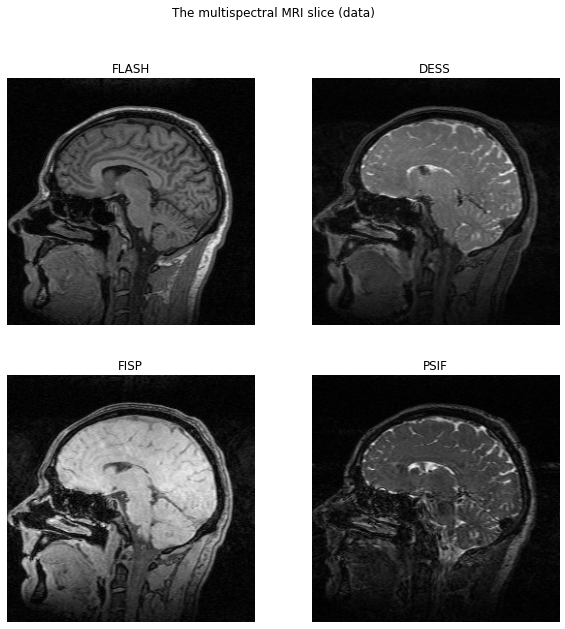

In [22]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    ax[k].imshow(data[:, :, k].T, cmap='gray', origin='lower')
    ax[k].set_title(ch)
    ax[k].set(xlabel="")
    ax[k].axis('off')
plt.suptitle("The multispectral MRI slice (data)") 
plt.tight_layout
plt.show()

### Constructing a Pandas data frame from the MRI data (img) and the ROI mask (roimsk)

In [23]:
roimsk_data = roimsk.get_fdata().squeeze()
# roimsk_data = np.ones(roimsk_data.shape)   # Using the whole image as ROI
roimsk_data.shape

(256, 256)

Find all pixel locations in the ROI for extracting a dataset X and corresponding pixel locations to a Pandas data frame (dfR)

In [24]:
# Find pixel locations (ind_roi) corresponding to brain ROI (value 1 inside ROI, 0 else) 
ind_roi = np.where(roimsk_data == 1) 
X = np.asarray(data[ind_roi[0][:],ind_roi[1][:],:]) # The multispectral signal intensities
dfR = pd.DataFrame(X, columns = chn_names)
dfR.insert(loc = len(dfR.columns),
           column = 'row',
           value = ind_roi[0])  # Row of pixel location
dfR.insert(loc = len(dfR.columns),
           column = 'col',
           value = ind_roi[1])  # Col of pixel location

In [25]:
X.shape

(35822, 4)

In [26]:
dfR.head()

,FLASH,DESS,FISP,PSIF,row,col
0,149,66,67,66,20,121
1,129,90,86,106,20,122
2,101,83,146,81,20,123
3,28,79,158,40,20,124
4,7,53,155,67,20,125


In [27]:
dfR.tail()

,FLASH,DESS,FISP,PSIF,row,col
35817,10,13,29,6,239,150
35818,8,18,29,6,239,151
35819,12,18,20,8,239,152
35820,0,20,25,16,239,153
35821,9,26,19,19,239,154


### OPTIONAL: Scaling* of feature vectors  (MRI signal inensity), channel-by-channel wthin the ROI mask

*) Scaling to zero mean and unit standard deviation

In [28]:
scaler = StandardScaler()  
scaler.fit(X.astype(float))

X_scaled = scaler.transform(X.astype(float))  

# Make data frame from scaled X_train og y_train to check scaling
dX_scaled = pd.DataFrame(X_scaled, columns=chn_names)
dy = pd.concat([dfR.row, dfR.col], axis=1)
X_scaled = pd.concat([dX_scaled, dy], axis=1)
X_scaled.head()

,FLASH,DESS,FISP,PSIF,row,col
0,1.107765,-0.118564,-0.557741,-0.343962,20,121
1,0.763861,0.362309,-0.295802,0.257753,20,122
2,0.282395,0.222054,0.531375,-0.118319,20,123
3,-0.972856,0.141909,0.696810,-0.735078,20,124
4,-1.333956,-0.379037,0.655451,-0.328920,20,125


In [29]:
X_scaled.describe(percentiles = [0.5]).round(4).T

,count,mean,std,min,50%,max
FLASH,35822.0,0.0000,1.0000,-1.4543,0.1620,4.6844
DESS,35822.0,-0.0000,1.0000,-1.4410,-0.1186,4.5299
FISP,35822.0,-0.0000,1.0000,-1.4814,0.0626,2.0754
PSIF,35822.0,0.0000,1.0000,-1.3368,0.0321,6.0794
row,35822.0,134.5855,56.4481,20.0000,136.0000,239.0000
col,35822.0,142.2969,50.9810,42.0000,142.0000,240.0000


## Unsupervised classification of multispectral MRI using K-means

In [30]:
X.shape  # n x p data matrix, n=samples, p = feature vector dimension

(35822, 4)

> # Start your experiments here:
(You can make a copy of the original notebook and name it<br> e.g. 
`my_6-sMRI-Kmeans-tissue-classification.ipynb`)

### Clustering the 4D multispectral data within the ROI mask 
####  LATER: _play with different values of `K`, `max_iter` and `tol`_

In [31]:
K = 16  # Number of clusters
max_iter = 300 # Max number of iteration
tol = 0.0001 # Tolerance
kmeans_model = KMeans(n_clusters=K, random_state=42, max_iter=max_iter, tol=tol)
print(kmeans_model)

KMeans(n_clusters=16, random_state=42)


In [32]:
# Fit the K-means model to the data
kmeans_fit = kmeans_model.fit(X)

In [33]:
print(kmeans_fit.labels_)
print('First centroid i p-dimensional feature vector space:\n', kmeans_fit.cluster_centers_[0,:])

[6 6 3 ... 5 5 5]
First centroid i p-dimensional feature vector space:
 [ 67.4622824   78.92069632 135.80754352 122.81237911]


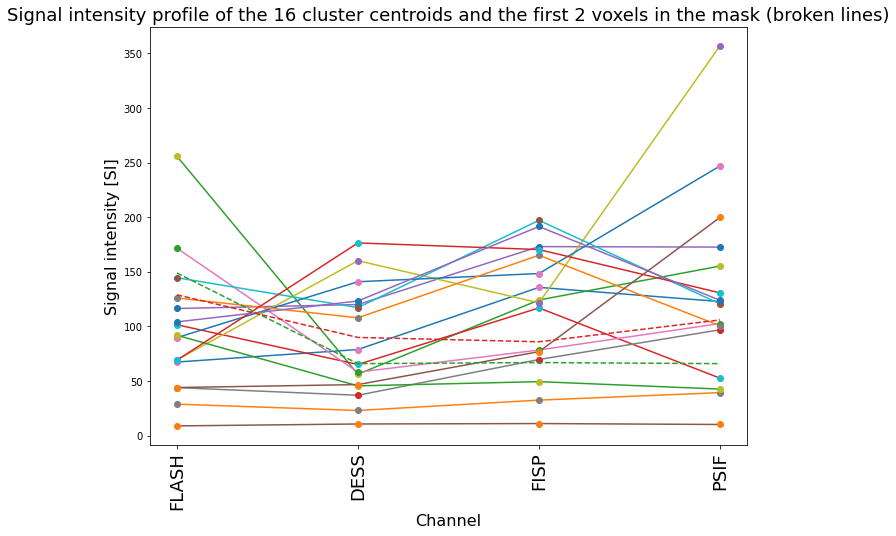

In [34]:
# Plot the cluster centroids as line plots

nv = 2

fig, ax = plt.subplots(1,1)

fig.set_size_inches(10, 7)

plt.plot(kmeans_fit.cluster_centers_.T)
plt.plot(kmeans_fit.cluster_centers_.T, 'o')
plt.plot(X[:nv, :].T, '--')
plt.xlabel('Channel', fontsize=16)
ax.set_xticks([x for x in range(len(chn_names))])
ax.set_xticklabels(chn_names, rotation='vertical', fontsize=18)
plt.ylabel('Signal intensity [SI]', fontsize=16)
#plt.xlim(0, 3)
plt.title('Signal intensity profile of the %d cluster centroids and the first %d voxels in the mask (broken lines)' % (K, nv), fontsize=18)

plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

**OPTIONAL:** Fit the K-means model to the scaled data

In [35]:
# Fit the K-means model to the scaled data
# kmeans_model_scaled = KMeans(n_clusters=K, random_state=42)
# kmeans_fit_scaled = kmeans_model_scaled.fit(X_scaled)

In [36]:
# print(kmeans_fit_scaled.labels_)
# print('First centroid in scaled p-dimensional feature vector space:\n', kmeans_fit_scaled.cluster_centers_[0,:])

#### Make a k-means segmented image (segmentation restricted to the ROI)

In [37]:
kmeans_segm = 0 * roimsk_data.copy()
print('Size of segmented image:', kmeans_segm.shape)
print('min:', kmeans_fit.labels_.min())
print('max:', kmeans_fit.labels_.max())
print('Number of clustered samples within ROI:', len(ind_roi[0]))

Size of segmented image: (256, 256)
min: 0
max: 15
Number of clustered samples within ROI: 35822


#### Assign the cluster belonging to each voxel within the ROI

In [38]:
for v in range(len(ind_roi[0])):
    kmeans_segm[ind_roi[0][v], ind_roi[1][v]] = kmeans_fit.labels_[v]

**and dsiplay the result (comparing with the FLASH channel)**

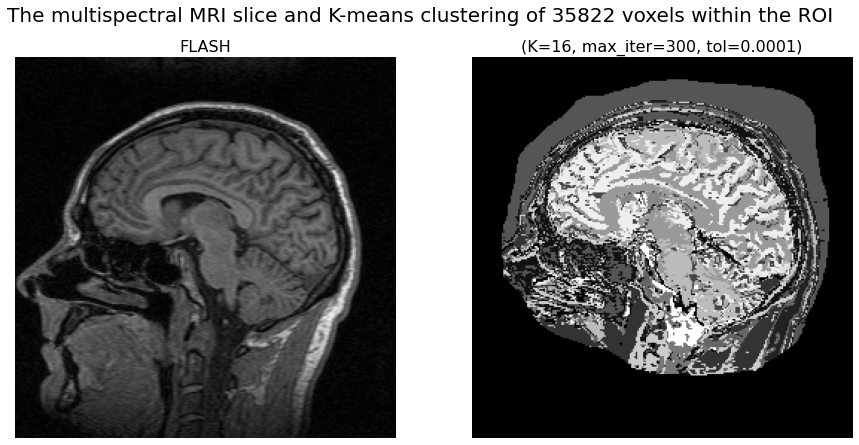

In [39]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
ax = axes.ravel()
ax[0].imshow(data[:, :, 0].T, cmap='gray', origin='lower')
ax[0].set_title(chn_names[0], fontsize=16)
ax[0].set(xlabel="")
ax[0].axis('off')
ax[1].imshow(kmeans_segm[:, :].T, cmap='gray', origin='lower')
ax[1].set_title('(K=%d, max_iter=%d, tol=%.4f)' % (K, max_iter, tol), fontsize=16)
ax[1].axis('off')
plt.suptitle('The multispectral MRI slice and K-means clustering of %d voxels within the ROI' % (X.shape[0]), fontsize=20) 
plt.tight_layout
plt.show()

**Design a new [colormap](https://matplotlib.org/tutorials/colors/colormap-manipulation.html) for the clustering, using [named colors](https://matplotlib.org/examples/color/named_colors.html) and gray levels, a colorcode 
[dictionary](https://www.geeksforgeeks.org/python-dictionary)**

In [40]:
import matplotlib
col_code = {
    'CLU0': [255,255,255], # White (background)
    'CLU1': [255,0,255],   # Magenta 
    'CLU2': [255,0,0],     # Red 
    'CLU3': [0,255,255],   # Cyan 
    'CLU4': [0,0,255],     # Blue 
    'CLU5': [0,255,0],     # Green 
    'CLU6': [255,255,0],   # Yellow 
    'CLU7': [10,10,10],    # Gray levels
    'CLU8': [20,20,20],    
    'CLU10': [40,40,40],
    'CLU11': [80,80,80],     
    'CLU12': [120,120,120],     
    'CLU13': [150,150,150],        
    'CLU14': [180,180,180],  
    'CLU15': [200,200,200]  
}
clu_names = list(col_code.keys())
nclu = len(clu_names)
colors = np.array(list(col_code.values()))/255   # scale to interval 0-1
mycmap = matplotlib.colors.ListedColormap(colors)
clu_cmap = matplotlib.cm.get_cmap(mycmap, nclu)   # nclu discrete colors

In [41]:
clu_names_num = []
for i in range(nclu):
    str = clu_names[i] + ' [%d]' % (i)
    clu_names_num.append(str)

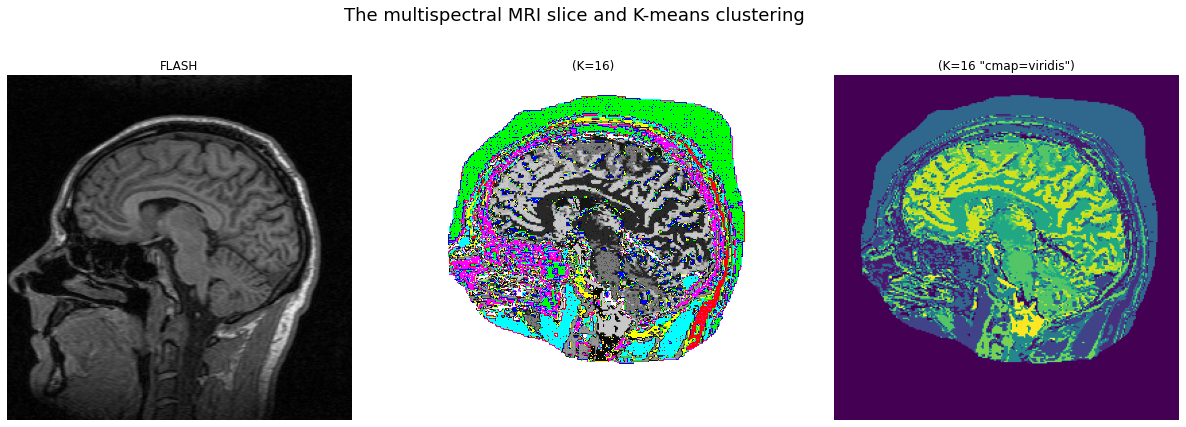

In [42]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
ax = axes.ravel()
ax[0].imshow(data[:, :, 0].T, cmap='gray', origin='lower')
ax[0].set_title(chn_names[0])
ax[0].set(xlabel="")
ax[0].axis('off')
ax[1].imshow(kmeans_segm[:, :].T, cmap=clu_cmap, origin='lower')
#ax[1].imshow(kmeans_segm[:, :].T, cmap='viridis', origin='lower')
#cmsk = ax[1].imshow(kmeans_segm[:, :].T, cmap=clu_cmap, origin='lower')
#clim=cmsk.properties()['clim']
#cbar = fig.colorbar(cmsk, shrink=0.4, label='Cluster [0-%d]' % clim[1])
#cbar.ax.set_yticklabels(clu_names_num)
ax[1].set_title('(K=%d)' % (K))
ax[1].axis('off')
ax[2].imshow(kmeans_segm[:, :].T, cmap='viridis', origin='lower')
ax[2].set_title('(K=%d "cmap=viridis")' % (K))
ax[2].axis('off')
plt.suptitle("The multispectral MRI slice and K-means clustering", fontsize=18) 
plt.tight_layout
plt.show()

### 3D scatterplot of clustered (color-coded) featurs vectors and the cluster centroids in 3D feature space

https://stackoverflow.com/questions/38364435/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook <br>
Using the [magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html) `%matplotlib notebook` instead of `%matplotlib inline`

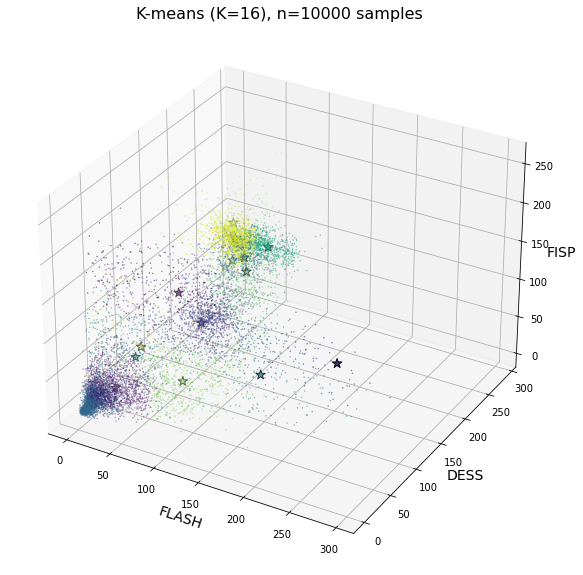

In [43]:
%matplotlib inline
# %matplotlib notebook

fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')

n=10000

xs = X[:n,0]
ys = X[:n,1]
zs = X[:n,2]
c = kmeans_fit.labels_[:n]

ax.scatter(xs, ys, zs, c=c, marker='.', s=0.5)

cxs = kmeans_fit.cluster_centers_[:,0]
cys = kmeans_fit.cluster_centers_[:,1]
czs = kmeans_fit.cluster_centers_[:,2]
cc = range(K)

ax.scatter(cxs, cys, czs, c=cc, marker='*', s=100,  edgecolors = 'black')


ax.set_xlabel('FLASH', size=14)
ax.set_ylabel('DESS', size=14)
ax.set_zlabel('FISP', size=14)

plt.title(f'K-means (K={K}), n={len(xs)} samples', size=16)
plt.show() 

## $\rightarrow$ Your turn!
> ## - Play with different values of `K`  (e.g. K=2, ...., 32)
> ## - Try to make biological (or MRI technical) interpretation of the clusters
> ## - Why does the K-means algorithm take longer to converge with increasing K ?
> ## - What does `random_state` do ?
> ## - Play with different values of `max_iter` and `tol` (explain your findings)
> ## - Try to formulate the k-means algorithm in the formalism of
## $$  y \approx f(\mathbf X, \theta) $$